# Assignment 1

Firstly, we load numerical and plotting libraries:

In [8]:
import math
import numpy as np
import matplotlib.pyplot as plt

We define some baseline parameters. We can later perform sensitivity analysis by varying these.

- $g$: gravitational acceleration ($m/s^2$)
- $y_0$: isothermal scale height ($m$)
- $B/m$: drag coefficient per unit mass ($m^{-1}$)
- $v_0$: initial launch speed ($m/s$)


In [21]:
g = 9.8                # m/s^2
y0 = 10000.0          # m
B_over_m = 4e-5        # 1/m  
v0 = 700.0             # m/s

There will be three regimes of interest:
- **"isothermal"**: where we use $\frac{\rho(y)}{\rho_0}=e^{-\frac{y}{y_0}}$ to model decreasing density with altitude.
- **"constant"**: where we keep density fixed, $\frac{\rho(y)}{\rho_0} =1$.
- **"none"** (or, no drag): we set $\frac{\rho(y)}{\rho_0}=0$ to disable drag.

It is then convenient to define a function that takes a string as input (beside the value of y), and outputs $\frac{\rho(y)}{\rho_0}$ according to the regime chosen.
We can also include a validation check to raise an error if the inputs are incorrect.

In [22]:
def rho_factor(y: float, mode: str) -> float:
    """Return density factor rho/rho0 as a function of altitude y."""
    if mode == "isothermal":
        return math.exp(-y / y0)
    if mode == "constant":
        return 1.0
    if mode == "none":  # Recall that this disables drag!
        return 0.0
    raise ValueError("mode must be 'isothermal', 'constant', or 'none'")

We will need to compute the components of the acceleration:

$a_x = -\frac{B}{m}\,\frac{\rho}{\rho_0}\,v\,v_x$

$a_y =  -g -\frac{B}{m}\,\frac{\rho}{\rho_0}\,v\,v_y$

with $v = \sqrt{v_x^2 + v_y^2}$, given the components of the velocity $(v_x,v_y)$, and the heigth $y$.
We then write a function that outputs the acceleration components as:


In [23]:
def accel(vx: float, vy: float, y: float, mode: str = "isothermal"):
    """Acceleration components (ax, ay) at height y with velocity (vx, vy)."""
    v = math.sqrt(vx**2 + vy**2)
    rho_fac = rho_factor(y, mode)
    ax = -B_over_m * rho_fac * v * vx
    ay = -g - B_over_m * rho_fac * v * vy
    return ax, ay

In order to solve the equations, we apply the forward Euler update.
The steps are the following:
1. We **evaluate** $(a_x,a_y)$ at the current state.
2. We **update** velocities: `vx_new = vx + ax*dt`, `vy_new = vy + ay*dt`.
3. We **update** positions using the *current* velocity (Euler): `x_new = x + vx*dt`, `y_new = y + vy*dt`.

We can to this in function that does this at each step, and then returns the updated quantities.


In [24]:
def step_euler(x, y, vx, vy, dt, mode="isothermal"):
    """Euler step for the projectile with drag."""
    ax, ay = accel(vx, vy, y, mode=mode)
    vx_new = vx + ax * dt
    vy_new = vy + ay * dt
    x_new  = x + vx * dt
    y_new  = y + vy * dt
    return x_new, y_new, vx_new, vy_new

We can now `simulate' the trajectories. 
For a given initial angle, we:
- **convert** the angle `theta_deg` to radians;
- **initialise** $(x,y)=(0,0)$ and $(v_x,v_y) = (v_0\cos\theta, v_0\sin\theta)$;
- **iterate** Euler steps, storing $(x,y)$ at each step;
- **stop** when `y < 0` (ground impact) or after `Nmax` steps;
- **return** NumPy arrays for plotting.

In [25]:
def simulate(theta_deg, mode="isothermal", dt=0.01, Nmax=200000):
    """Simulate the projectile path until it hits the ground (y <= 0)."""
    theta = math.radians(theta_deg)
    vx = v0 * math.cos(theta)
    vy = v0 * math.sin(theta)
    x, y = 0.0, 0.0
    xs, ys = [x], [y]
    for _ in range(Nmax):
        x, y, vx, vy = step_euler(x, y, vx, vy, dt, mode=mode)
        xs.append(x)
        ys.append(y)
        if y < 0:
            break
    return np.array(xs), np.array(ys)



Finally, we can plot the simulated trajectories, for some choices of the angles:


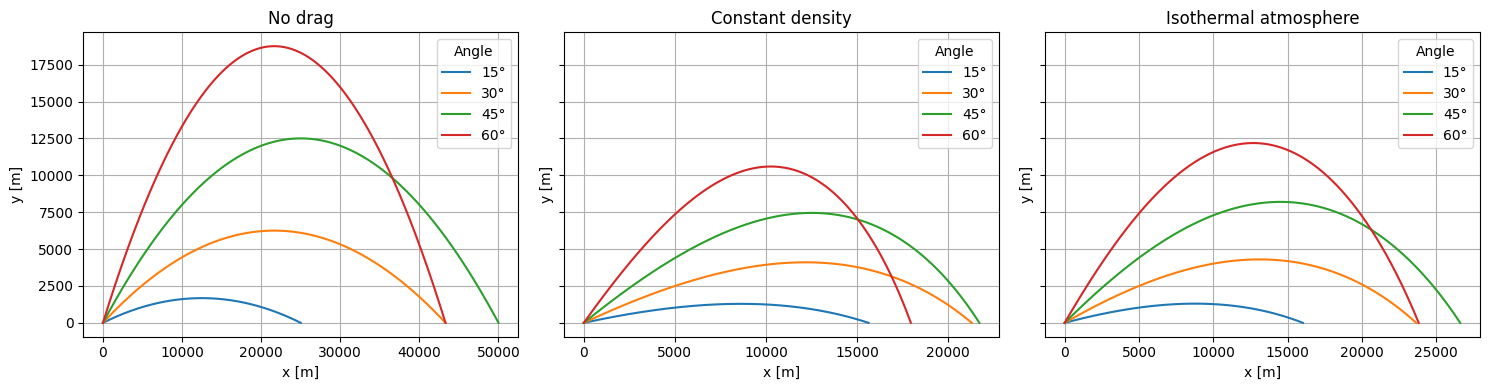

In [34]:
if __name__ == "__main__":
    # angles to compare
    angles_deg = [15, 30, 45, 60]
    modes = [
        ("none",       "No drag"),
        ("constant",   "Constant density"),
        ("isothermal", "Isothermal atmosphere"),
    ]

    fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
    for ax, (mode, title) in zip(axs, modes):
        for th in angles_deg:
            xs, ys = simulate(th, mode=mode, dt=0.01, Nmax=50000)
            ax.plot(xs, ys, label=f"{th}°")
        ax.set_title(title)
        ax.set_xlabel("x [m]")
        ax.set_ylabel("y [m]")
        ax.legend(title="Angle")
        ax.grid(True)

    plt.tight_layout()
    plt.show()